In [1]:
%reload_ext autoreload
%autoreload all

%aimport -torch
%aimport -matplotlib
%aimport -seaborn
%aimport -numpy
%aimport -pandas
%aimport -scipy
%aimport -lightning 

In [2]:
import torch
from torch.utils.data import DataLoader

from eeg_snn_encoder.config import PROCESSED_DATA_DIR
from eeg_snn_encoder.dataset import CHBMITDataset

torch.set_float32_matmul_precision("high")

2025-05-19 00:28:12.359 | INFO     | eeg_snn_encoder.config:<module>:11 - PROJ_ROOT path is: E:\Projects\snn-encoder-test


In [3]:
# Load the dataset
dataset = CHBMITDataset(PROCESSED_DATA_DIR / "stft_normalized.h5")
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)

In [4]:
import matplotlib as mpl

mpl.rcParams["font.family"] = "Montserrat"
mpl.rcParams["font.weight"] = "medium"

In [5]:
from eeg_snn_encoder.encoders import (
    BSAEncoder,
    BurstEncoder,
    PhaseEncoder,
    PoissonEncoder,
    StepForwardEncoder,
    TBREncoder,
)

encoders = {
    "be": BurstEncoder(max_window=8, n_max=7, t_max=0, t_min=0),
    "pe": PhaseEncoder(phase_window=3),
    "poisson": PoissonEncoder(interval_freq=8, random_seed=47),
    "bsa": BSAEncoder(win_size=2, cutoff=0.07092405753357992, threshold=0.24161293848320511),
    "sf": StepForwardEncoder(threshold=0.19608781936180755),
    "tbr": TBREncoder(threshold=0.4255145783486303),
}

In [6]:
# import math

# from tqdm.notebook import tqdm

# results = []

# for name, encoder in encoders.items():
#     loader = tqdm(dataloader, desc=f"Testing {name} encoder", leave=False)

#     loss_sum = 0
#     x_count = 0
#     batch_count = 0

#     spike_count = []

#     for x, y in loader:
#         x: torch.Tensor = x.to(device="cuda")
#         y: torch.Tensor = y.to(device="cuda")

#         encoded_data = encoder.encode(x)

#         decoded_params = encoder.get_decode_params(x)

#         decoded_data = encoder.decode(encoded_data, decoded_params)[..., : x.shape[3]]

#         squared_error = torch.sum((decoded_data - x) ** 2)

#         loss_sum += squared_error.item()
#         x_count += x.numel()
#         batch_count += x.shape[0]
#         spike_count.append(encoded_data.count_nonzero().item())

#     avg_loss = loss_sum / x_count
#     rmse = math.sqrt(avg_loss)
#     spike_count = sum(spike_count) / batch_count

#     results.append(
#         {
#             "encoder": name,
#             "rmse": rmse,
#             "spike_count": spike_count,
#         }
#     )

In [7]:
# import pandas as pd

# from eeg_snn_encoder.config import REPORTS_DIR

# encoder_results = pd.read_csv(
#     REPORTS_DIR / "encoder_result.csv"
# )
# encoder_results = encoder_results.set_index("encoder")

In [9]:
# encoder_results

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["font.family"] = "Montserrat"
mpl.rcParams["font.weight"] = "medium"

In [ ]:
import os
import optuna

encoder_study = optuna.load_study(
        study_name="model-tuning-be-new",
        storage=os.environ["OPTUNA_CONN_STRING_CPE"],
    )

In [12]:
# fig, ax1 = plt.subplots(figsize=(8, 6))
# sns.barplot(
#     data=encoder_results,
#     x=encoder_results.index,
#     y="spike_count",
#     ax=ax1,
#     color="#309898",
# )
# ax2 = ax1.twinx()
# sns.lineplot(
#     data=encoder_results,
#     x=encoder_results.index,
#     y="rmse",
#     ax=ax2,
#     color="#8c52ff",
#     marker="o",
#     linewidth=3,
# )
# ax1.set_ylabel("Spike Fired", fontdict={"fontsize": 12, "weight": "medium"})
# ax2.set_ylabel("RMSE", fontdict={"fontsize": 12, "weight": "medium"})
# ax2.set_ylim(0.05, 0.6)
# ax1.set_xlabel("Encoders", fontdict={"fontsize": 12, "weight": "medium"})
# ax1.set_title(
#     "Spike Fired and RMSE for Different Encoders",
#     fontdict={"fontsize": 14, "weight": "medium"},
# )
# ax1.set_ylim(20000, 90000)
# for i in ax1.containers:
#     ax1.bar_label(i, fmt=lambda x: f"{x:,.0f}")

# labels = list(zip(encoder_results.index, encoder_results["rmse"]))

# for x, y in labels:
#     ax2.text(x, y - 0.05, f"{y:.2f}", color="white", ha="center", va="bottom")

In [13]:
# fig.savefig(REPORTS_DIR / "figures" / "encoder_result.svg", transparent=True)

In [14]:
data, labels = next(iter(dataloader))

In [ ]:
import numpy as np


def plot_encoding_comparison(data: torch.Tensor, encoder="be", title="Burst Encoding", show=True):
    timestep = data.shape[-1]
    x = np.arange(0, timestep)
    encoded_data = encoders[encoder].encode(data)
    decoded_params = encoders[encoder].get_decode_params(data)
    decoded_data = encoders[encoder].decode(encoded_data, decoded_params)[..., : timestep]

    fig, axes = plt.subplots(nrows=2, figsize=(12, 5), sharex=True)
    sns.lineplot(x=x, y=data[0, 0, 0], label="Original Signal", color="#309898", ax=axes[0])
    sns.lineplot(x=x, y=decoded_data[0, 0, 0], label="Decoded Signal", color="#fb7e3e", ax=axes[0])
    stem = axes[1].stem(encoded_data[0, 0, 0], label="Encoded Signal", markerfmt=" ", linefmt="-", basefmt="-")
    stem[1].set_color("#375da5")
    stem[2].set_color("#febd2e")
    axes[0].set_ylabel("")
    axes[0].set_title(title, fontdict={"fontsize": 14, "weight": "medium"})
    axes[1].set_xlabel("Timestep")
    axes[1].set_xticks(np.arange(0, 69, 8))
    axes[1].set_xlim(-1, 70)
    fig.tight_layout()
    
    if show:
        plt.show()

    return fig, axes

In [ ]:
plt.close("all")
fig, axes = plot_encoding_comparison(data, encoder="be", title="Burst Encoding")

NameError: name 'plt' is not defined

In [49]:
from eeg_snn_encoder.config import REPORTS_DIR

fig.savefig(
    REPORTS_DIR / "figures" / "encoder_comparison_be.svg",
    transparent=True,
)

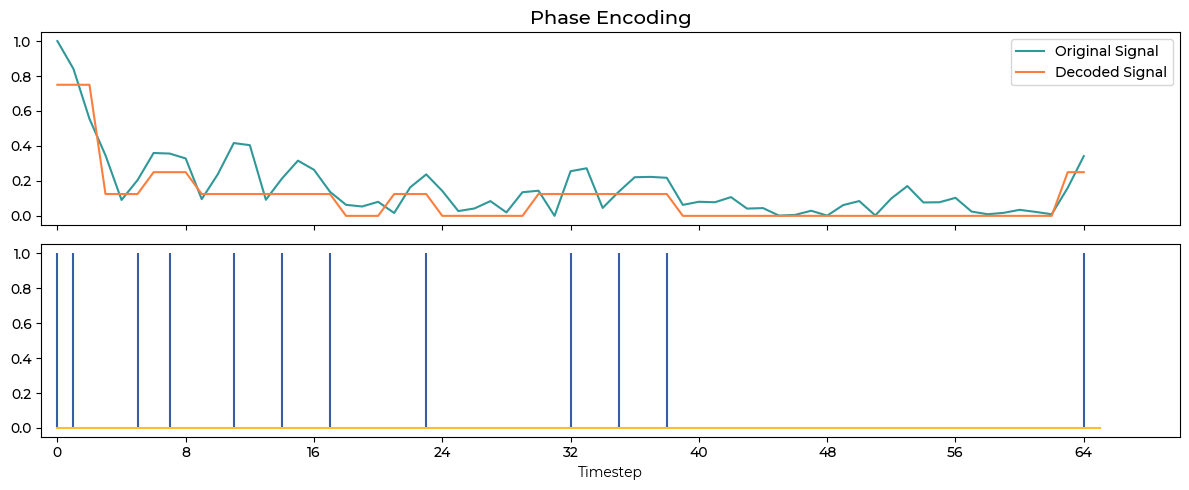

In [50]:
plt.close("all")
fig, axes = plot_encoding_comparison(data, encoder="pe", title="Phase Encoding")

In [51]:
from eeg_snn_encoder.config import REPORTS_DIR

fig.savefig(
    REPORTS_DIR / "figures" / "encoder_comparison_pe.svg",
    transparent=True,
)

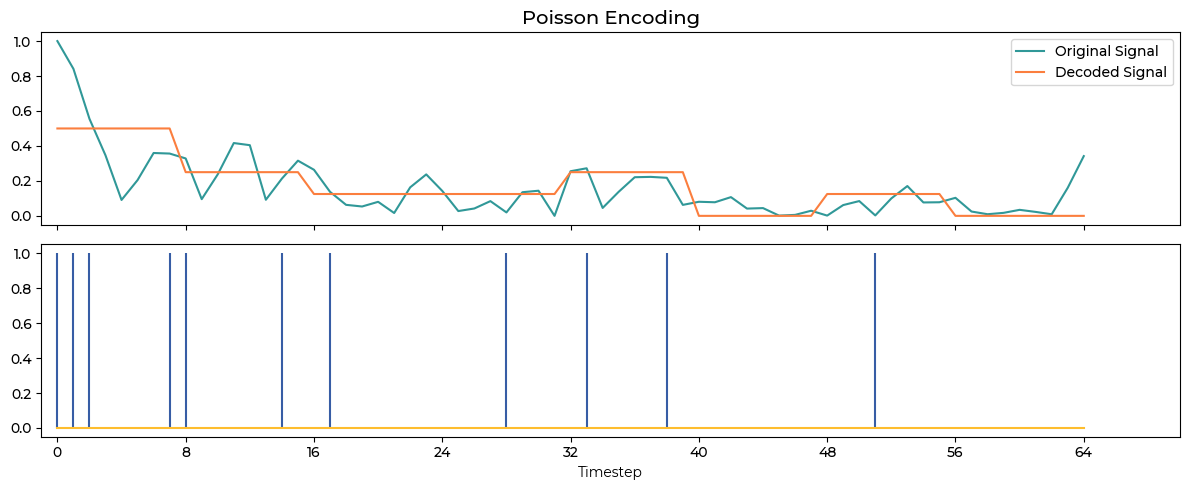

In [52]:
plt.close("all")
fig, axes = plot_encoding_comparison(data, encoder="poisson", title="Poisson Encoding")

In [53]:
from eeg_snn_encoder.config import REPORTS_DIR

fig.savefig(
    REPORTS_DIR / "figures" / "encoder_comparison_poisson.svg",
    transparent=True,
)

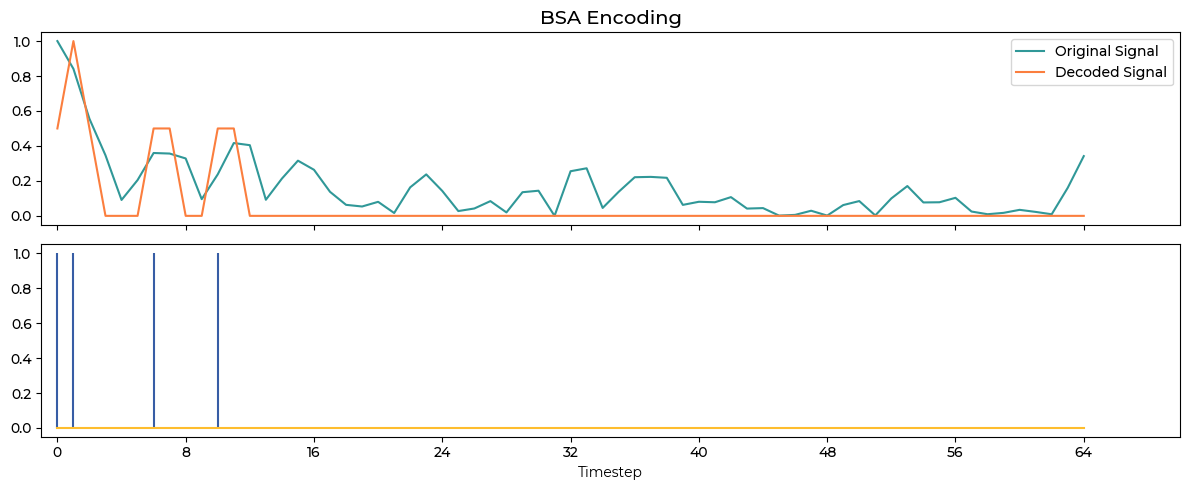

In [54]:
plt.close("all")
fig, axes = plot_encoding_comparison(data, encoder="bsa", title="BSA Encoding")

In [55]:
from eeg_snn_encoder.config import REPORTS_DIR

fig.savefig(
    REPORTS_DIR / "figures" / "encoder_comparison_bsa.svg",
    transparent=True,
)

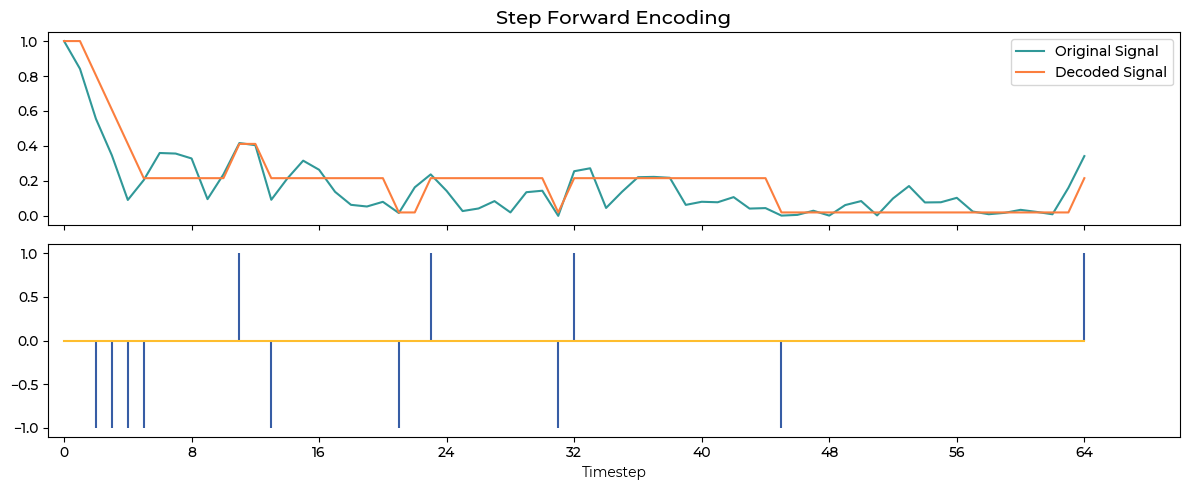

In [56]:
plt.close("all")
fig, axes = plot_encoding_comparison(data, encoder="sf", title="Step Forward Encoding")

In [57]:
from eeg_snn_encoder.config import REPORTS_DIR

fig.savefig(
    REPORTS_DIR / "figures" / "encoder_comparison_sf.svg",
    transparent=True,
)

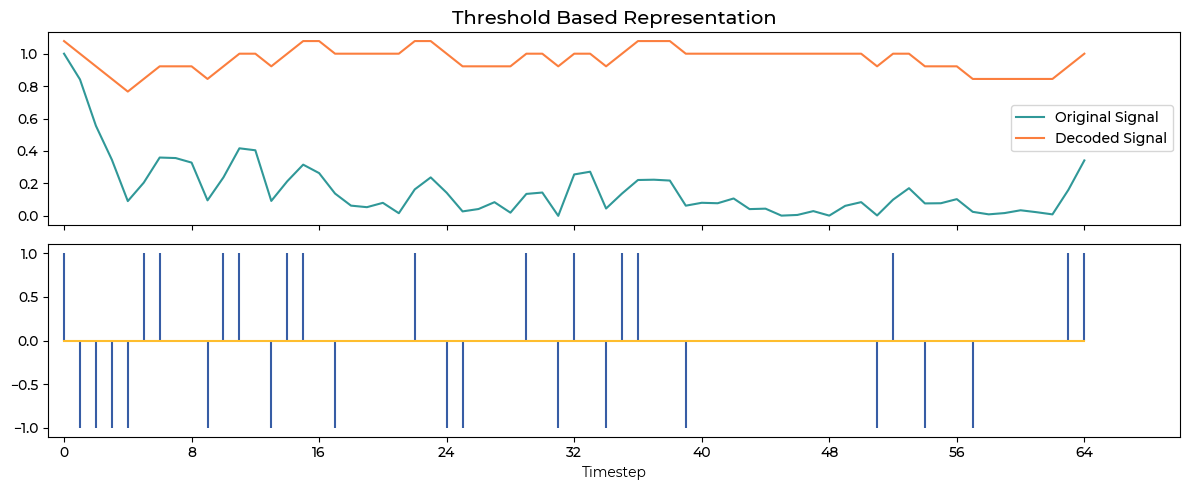

In [58]:
plt.close("all")
fig, axes = plot_encoding_comparison(data, encoder="tbr", title="Threshold Based Representation")

In [59]:
from eeg_snn_encoder.config import REPORTS_DIR

fig.savefig(
    REPORTS_DIR / "figures" / "encoder_comparison_tbr.svg",
    transparent=True,
)

In [60]:
from mne.io import read_raw_edf

from eeg_snn_encoder.config import RAW_DATA_DIR

test_path = RAW_DATA_DIR / "chb-mit" / "chb01" / "chb01_01.edf"

In [61]:
test_raw = read_raw_edf(test_path, preload=True)

Extracting EDF parameters from E:\Projects\snn-encoder-test\data\raw\chb-mit\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\HomeUser\AppData\Local\Temp\ipykernel_32092\469202175.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  test_raw = read_raw_edf(test_path, preload=True)


In [62]:
test_raw

<RawEDF | chb01_01.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>

In [63]:
import matplotlib.pyplot as plt

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


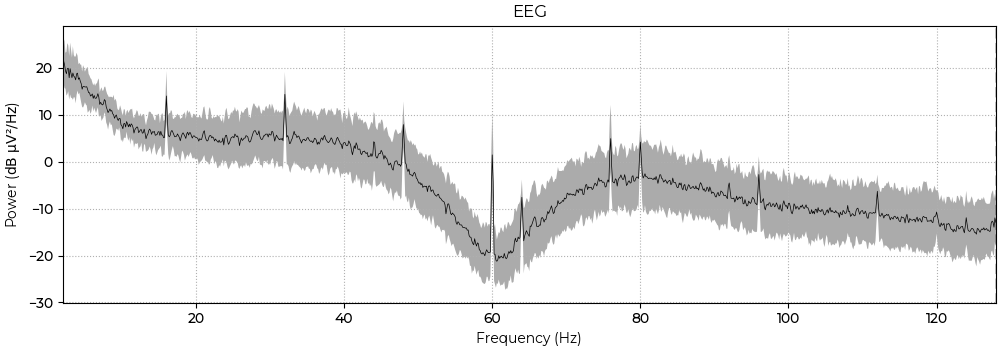

In [ ]:
plt.close("all")
fig = test_raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=128, average=True, show=False);

In [ ]:
fig.savefig(REPORTS_DIR / "figures" / "psd.svg", transparent=True)

In [66]:
test_raw.notch_filter(60)
test_raw.filter(l_freq=0.5, h_freq=80, fir_design="firwin")

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.3s finished


<RawEDF | chb01_01.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


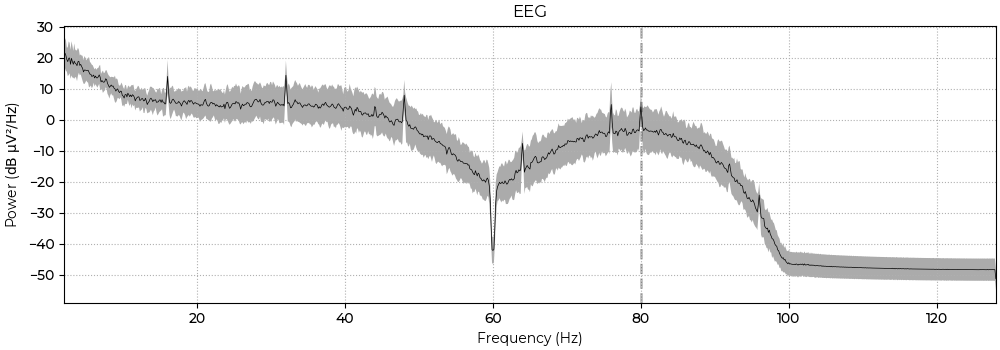

In [67]:
plt.close("all")
fig = test_raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=128, average=True, show=False);

In [ ]:
fig.savefig(REPORTS_DIR / "figures" / "filterd_psd.svg", transparent=True)